In [ ]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from jaxtyping import Float

from qft_nn.nn.sae import AutoEncoder, AutoEncoderConfig, extract_toy_model_activations
from qft_nn.nn.toy_model import SingleLayerToyReLUModelConfig, SingleLayerToyReLUModel
from qft_nn.ntk import compute_empirical_ntk

from qft_nn.nn.base_config import TrainConfig
from qft_nn.nn.lr_schedules import constant_lr

train_config = TrainConfig(
    n_instances=1,
    batch_size=1024,
    steps=10_000,
    log_freq=100,
    lr=1e-3,
    lr_scale=constant_lr,
    data_seed=1337
)

toy_model_config = SingleLayerToyReLUModelConfig(
    n_features=5,
    n_hidden=32,
    n_correlated_pairs=2,
    n_anticorrelated_pairs=1,
    train=train_config
)

sae_config = AutoEncoderConfig(
    n_input_ae = 32,
    n_hidden_ae = 64,
    l1_coeff = 1.0,
    tied_weights = False,
    train=train_config,
)

toy_model = SingleLayerToyReLUModel(cfg=toy_model_config, device='cpu')
toy_model.optimize()

sae = AutoEncoder(cfg=sae_config, device='cpu')
sae.optimize(model=toy_model)

data_labels = toy_model.generate_batch(25)
data_input = toy_model(data_labels)
dataset = TensorDataset(data_input, data_labels)

entk = compute_empirical_ntk(model=toy_model, criterion=toy_model.calculate_loss, data=dataset)

sae_matrix = extract_toy_model_activations(toy_model=toy_model, sae=sae, batch_size=25)
sae_dependency_graph = (sae_matrix @ sae_matrix.T).numpy()

assert sae_dependency_graph.shape == entk.shape


100%|██████████| 10000/10000 [00:41<00:00, 239.20it/s, l1_loss=0.00362, l2_loss=0.408, lr=0.001]


In [9]:

import numpy as np

def _get_top_k_connections(dependency_matrix: Float[np.ndarray, "num_data num_data"], k: int=10) -> Dict[int, Tuple[int, List[int]]]:
    n_nodes = dependency_matrix.shape[0]
    assert k <= n_nodes - 1, "k must be smaller than n_nodes - 1"

    result = {}    
    for i in range(n_nodes):
        connections = dependency_matrix[i]
        node_connections = [(j, connections[j]) for j in range(n_nodes) if j != i]
        sorted_connections = sorted(node_connections, key=lambda x: x[1], reverse=True)        
        result[i] = sorted_connections[:k]
    return result

def _plot_heatmap(matrix: Float[np.ndarray, "num_data num_data"], title: str, figsize: int=(10,8), cmap: str = "Blues", annot: bool=True, fmt=".2f"):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(matrix, annot=annot, fmt=fmt, cmap=cmap, ax=ax)
    ax.set_title(title)
    
    if len(matrix.shape) == 2:
        ax.set_xlabel("Column Index")
        ax.set_ylabel("Row Index")
    
    plt.tight_layout()
    plt.show()


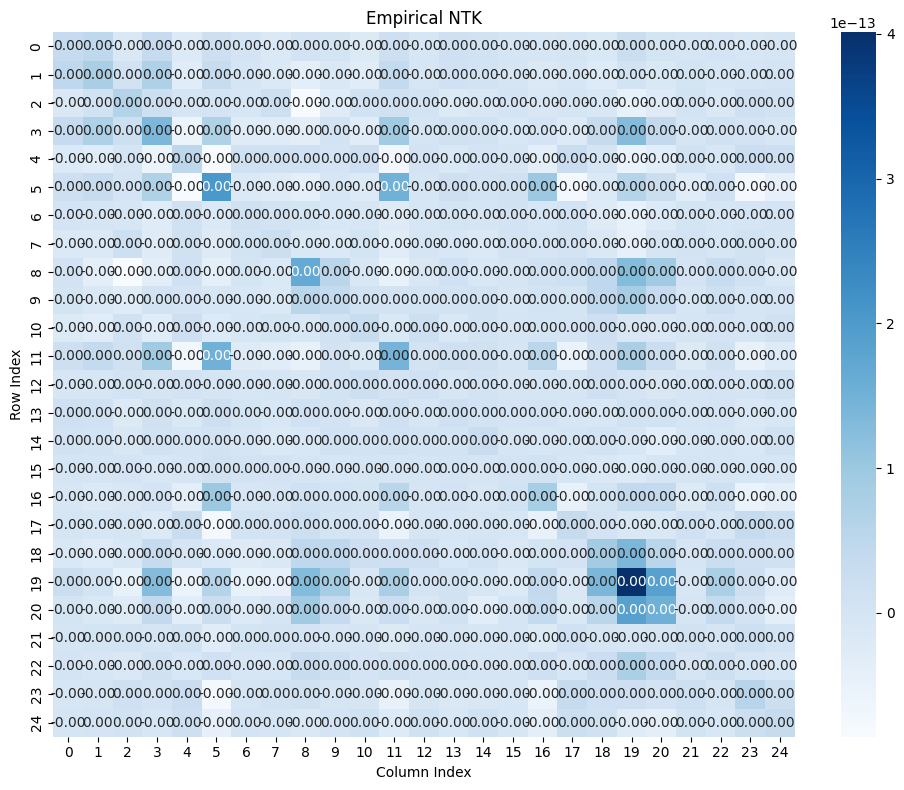

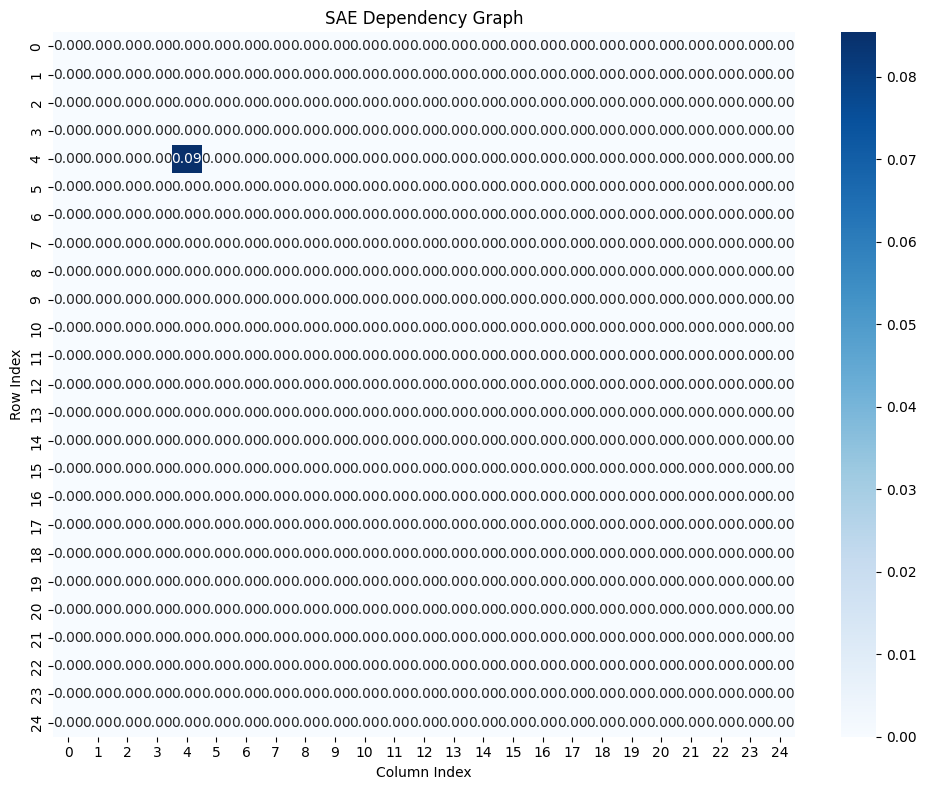

In [13]:
_plot_heatmap(matrix=entk, title="Empirical NTK")
_plot_heatmap(matrix=sae_dependency_graph, title="SAE Dependency Graph")    

# Compare top k
k = 10
sae_top_10_connections = _get_top_k_connections(dependency_matrix=sae_dependency_graph, k=k)
entk_top_10_connections =  _get_top_k_connections(dependency_matrix=entk, k=k)

In [15]:
for i in range(0, k):
    print(f"Feature: {i}")
    print(f"ENTK top k indices: {[entk_top_10_connections[i][j][0] for j in range(0, k)]}")
    print(f"SAE top k indices: {[sae_top_10_connections[i][j][0] for j in range(0, k)]}")
    print(f"ENTK & SAE top k indices absolute difference: {[abs(sae_top_10_connections[i][j][1] - entk_top_10_connections[i][j][1]) for j in range (0, k)]}")
    print("\n")

Feature: 0
ENTK top k indices: [1, 3, 19, 11, 5, 13, 14, 8, 20, 9]
SAE top k indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ENTK & SAE top k indices absolute difference: [np.float32(4.5932452e-14), np.float32(3.6910738e-14), np.float32(2.4711061e-14), np.float32(2.085066e-14), np.float32(2.0427824e-14), np.float32(1.5394897e-14), np.float32(8.54277e-15), np.float32(3.919388e-15), np.float32(3.5361584e-15), np.float32(1.8636667e-15)]


Feature: 1
ENTK top k indices: [3, 0, 11, 5, 13, 2, 19, 14, 21, 24]
SAE top k indices: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ENTK & SAE top k indices absolute difference: [np.float32(7.236691e-14), np.float32(4.5932452e-14), np.float32(3.9822302e-14), np.float32(3.122279e-14), np.float32(1.353641e-14), np.float32(8.9150175e-15), np.float32(6.97511e-15), np.float32(6.5940583e-15), np.float32(2.6773795e-15), np.float32(7.716181e-16)]


Feature: 2
ENTK top k indices: [7, 3, 23, 11, 10, 1, 24, 12, 21, 5]
SAE top k indices: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
ENTK & SAE top k